In [7]:
sd = 123 # Here sd means seed.
mpl.rcParams['figure.figsize'] = (16, 6)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.LstmStrategy as sl

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense,Dropout
from keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import random as rn


np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
tf.random.set_seed(sd)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sd = 123 # Here sd means seed.
mpl.rcParams['figure.figsize'] = (16, 6)

In [8]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

stock_list=['ICE', 'WLTW']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]
test_data['realcombo_before_std']=test_data.realcombo
#standard
realcombo_mean=test_data.realcombo.mean()
realcombo_std=test_data.realcombo.std()
test_data.realcombo=(test_data.realcombo-test_data.realcombo.mean())/test_data.realcombo.std()


In [9]:
test_data

Date        ICE        WLTW  Dog_leash  realcombo  \
0    2005-11-22   6.342704   69.851379  58.752772   2.643456   
1    2005-11-23   6.161225   69.651382  59.311547   2.655225   
2    2005-11-25   6.197519   69.724091  59.515885   2.656692   
3    2005-11-28   6.043263   68.378700  59.294517   2.529390   
4    2005-11-29   5.801895   67.324211  58.861839   2.452934   
...         ...        ...         ...        ...        ...   
3766 2020-11-09  98.220001  196.000000  24.116557  -0.406221   
3767 2020-11-10  98.000000  202.009995  27.773579   0.338432   
3768 2020-11-11  99.980003  202.949997  30.976658   0.064945   
3769 2020-11-12  98.309998  202.199997  34.950952   0.300618   
3770 2020-11-13  99.349998  206.809998  38.313129   0.637814   

      realcombo_before_std  
0                59.340512  
1                59.441256  
2                59.453819  
3                58.364055  
4                57.709551  
...                    ...  
3766             33.233881  
3767             39.608453  
3768             37.267276  
3769             39.284740  
3770             42.171294  

[3771 rows x 6 columns]

In [ ]:
trendpredict=[]
count=-1

for i in range(2000,test_data.shape[0]-200):
    count=count+1
    if count%100==0 and count>1:
        print(f'completed 100. on iteration {i}')
    for sd in [123,789,456,329]:
        future=sl.build_model_and_predict(test_data,i,i+200,seed=sd)
        trend=sl.trendHelper(future)
        print(f'at idx {i+200} seed {sd} predicted trend is: {trend}')
        if trend != '-':
            break;
    trendpredict.append([i+200,test_data.iloc[i+200,0],trend,sd]) 
#trendpredict    
#profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
#print(profit_cumulative)

at idx 2200 seed 123 predicted trend is: DOWN
at idx 2201 seed 123 predicted trend is: UP
at idx 2202 seed 123 predicted trend is: DOWN
at idx 2203 seed 123 predicted trend is: DOWN
at idx 2204 seed 123 predicted trend is: DOWN
at idx 2205 seed 123 predicted trend is: UP
at idx 2206 seed 123 predicted trend is: DOWN
at idx 2207 seed 123 predicted trend is: UP
at idx 2208 seed 123 predicted trend is: -
at idx 2208 seed 789 predicted trend is: DOWN
at idx 2209 seed 123 predicted trend is: -
at idx 2209 seed 789 predicted trend is: DOWN
at idx 2210 seed 123 predicted trend is: -
at idx 2210 seed 789 predicted trend is: -
at idx 2210 seed 456 predicted trend is: -
at idx 2210 seed 329 predicted trend is: -
at idx 2211 seed 123 predicted trend is: -
at idx 2211 seed 789 predicted trend is: DOWN
at idx 2212 seed 123 predicted trend is: -
at idx 2212 seed 789 predicted trend is: DOWN
at idx 2213 seed 123 predicted trend is: DOWN
at idx 2214 seed 123 predicted trend is: DOWN
at idx 2215 seed 1

at idx 2271 seed 123 predicted trend is: -
at idx 2271 seed 789 predicted trend is: -
at idx 2271 seed 456 predicted trend is: -
at idx 2271 seed 329 predicted trend is: -
at idx 2272 seed 123 predicted trend is: -
at idx 2272 seed 789 predicted trend is: -
at idx 2272 seed 456 predicted trend is: -
at idx 2272 seed 329 predicted trend is: -
at idx 2273 seed 123 predicted trend is: -
at idx 2273 seed 789 predicted trend is: -
at idx 2273 seed 456 predicted trend is: -
at idx 2273 seed 329 predicted trend is: -
at idx 2274 seed 123 predicted trend is: -
at idx 2274 seed 789 predicted trend is: -
at idx 2274 seed 456 predicted trend is: -
at idx 2274 seed 329 predicted trend is: -
at idx 2275 seed 123 predicted trend is: -
at idx 2275 seed 789 predicted trend is: -
at idx 2275 seed 456 predicted trend is: -
at idx 2275 seed 329 predicted trend is: -
at idx 2276 seed 123 predicted trend is: -
at idx 2276 seed 789 predicted trend is: -
at idx 2276 seed 456 predicted trend is: -
at idx 2276

at idx 2355 seed 123 predicted trend is: DOWN
at idx 2356 seed 123 predicted trend is: -
at idx 2356 seed 789 predicted trend is: -
at idx 2356 seed 456 predicted trend is: -
at idx 2356 seed 329 predicted trend is: -
at idx 2357 seed 123 predicted trend is: -
at idx 2357 seed 789 predicted trend is: -
at idx 2357 seed 456 predicted trend is: -
at idx 2357 seed 329 predicted trend is: -
at idx 2358 seed 123 predicted trend is: -
at idx 2358 seed 789 predicted trend is: -
at idx 2358 seed 456 predicted trend is: -
at idx 2358 seed 329 predicted trend is: -
at idx 2359 seed 123 predicted trend is: -
at idx 2359 seed 789 predicted trend is: -
at idx 2359 seed 456 predicted trend is: -
at idx 2359 seed 329 predicted trend is: DOWN
at idx 2360 seed 123 predicted trend is: -
at idx 2360 seed 789 predicted trend is: -
at idx 2360 seed 456 predicted trend is: -
at idx 2360 seed 329 predicted trend is: -
at idx 2361 seed 123 predicted trend is: -
at idx 2361 seed 789 predicted trend is: -
at id

at idx 2421 seed 789 predicted trend is: -
at idx 2421 seed 456 predicted trend is: -
at idx 2421 seed 329 predicted trend is: -
at idx 2422 seed 123 predicted trend is: -
at idx 2422 seed 789 predicted trend is: -
at idx 2422 seed 456 predicted trend is: DOWN
at idx 2423 seed 123 predicted trend is: -
at idx 2423 seed 789 predicted trend is: DOWN
at idx 2424 seed 123 predicted trend is: -
at idx 2424 seed 789 predicted trend is: -
at idx 2424 seed 456 predicted trend is: DOWN
at idx 2425 seed 123 predicted trend is: -
at idx 2425 seed 789 predicted trend is: -
at idx 2425 seed 456 predicted trend is: -
at idx 2425 seed 329 predicted trend is: DOWN
at idx 2426 seed 123 predicted trend is: -
at idx 2426 seed 789 predicted trend is: -
at idx 2426 seed 456 predicted trend is: DOWN
at idx 2427 seed 123 predicted trend is: UP
at idx 2428 seed 123 predicted trend is: UP
at idx 2429 seed 123 predicted trend is: -
at idx 2429 seed 789 predicted trend is: -
at idx 2429 seed 456 predicted trend 

at idx 2484 seed 123 predicted trend is: -
at idx 2484 seed 789 predicted trend is: -
at idx 2484 seed 456 predicted trend is: -
at idx 2484 seed 329 predicted trend is: -
at idx 2485 seed 123 predicted trend is: -
at idx 2485 seed 789 predicted trend is: -
at idx 2485 seed 456 predicted trend is: -
at idx 2485 seed 329 predicted trend is: -
at idx 2486 seed 123 predicted trend is: -
at idx 2486 seed 789 predicted trend is: -
at idx 2486 seed 456 predicted trend is: -
at idx 2486 seed 329 predicted trend is: -
at idx 2487 seed 123 predicted trend is: -
at idx 2487 seed 789 predicted trend is: -
at idx 2487 seed 456 predicted trend is: -
at idx 2487 seed 329 predicted trend is: -
at idx 2488 seed 123 predicted trend is: -
at idx 2488 seed 789 predicted trend is: -
at idx 2488 seed 456 predicted trend is: -
at idx 2488 seed 329 predicted trend is: -
at idx 2489 seed 123 predicted trend is: -
at idx 2489 seed 789 predicted trend is: -
at idx 2489 seed 456 predicted trend is: -
at idx 2489

at idx 2531 seed 456 predicted trend is: -
at idx 2531 seed 329 predicted trend is: -
at idx 2532 seed 123 predicted trend is: -
at idx 2532 seed 789 predicted trend is: -
at idx 2532 seed 456 predicted trend is: -
at idx 2532 seed 329 predicted trend is: -
at idx 2533 seed 123 predicted trend is: -
at idx 2533 seed 789 predicted trend is: -
at idx 2533 seed 456 predicted trend is: -
at idx 2533 seed 329 predicted trend is: -
at idx 2534 seed 123 predicted trend is: -
at idx 2534 seed 789 predicted trend is: -
at idx 2534 seed 456 predicted trend is: -
at idx 2534 seed 329 predicted trend is: -
at idx 2535 seed 123 predicted trend is: -
at idx 2535 seed 789 predicted trend is: -
at idx 2535 seed 456 predicted trend is: -
at idx 2535 seed 329 predicted trend is: -
at idx 2536 seed 123 predicted trend is: -
at idx 2536 seed 789 predicted trend is: -
at idx 2536 seed 456 predicted trend is: -
at idx 2536 seed 329 predicted trend is: -
at idx 2537 seed 123 predicted trend is: -
at idx 2537

at idx 2582 seed 329 predicted trend is: -
at idx 2583 seed 123 predicted trend is: -
at idx 2583 seed 789 predicted trend is: -
at idx 2583 seed 456 predicted trend is: -
at idx 2583 seed 329 predicted trend is: -
at idx 2584 seed 123 predicted trend is: -
at idx 2584 seed 789 predicted trend is: -
at idx 2584 seed 456 predicted trend is: -
at idx 2584 seed 329 predicted trend is: -
at idx 2585 seed 123 predicted trend is: -
at idx 2585 seed 789 predicted trend is: -
at idx 2585 seed 456 predicted trend is: -
at idx 2585 seed 329 predicted trend is: -
at idx 2586 seed 123 predicted trend is: -
at idx 2586 seed 789 predicted trend is: -
at idx 2586 seed 456 predicted trend is: -
at idx 2586 seed 329 predicted trend is: -
at idx 2587 seed 123 predicted trend is: -
at idx 2587 seed 789 predicted trend is: -
at idx 2587 seed 456 predicted trend is: -
at idx 2587 seed 329 predicted trend is: -
at idx 2588 seed 123 predicted trend is: -
at idx 2588 seed 789 predicted trend is: -
at idx 2588

at idx 2643 seed 329 predicted trend is: -
at idx 2644 seed 123 predicted trend is: -
at idx 2644 seed 789 predicted trend is: -
at idx 2644 seed 456 predicted trend is: -
at idx 2644 seed 329 predicted trend is: -
at idx 2645 seed 123 predicted trend is: -
at idx 2645 seed 789 predicted trend is: -
at idx 2645 seed 456 predicted trend is: -
at idx 2645 seed 329 predicted trend is: -
at idx 2646 seed 123 predicted trend is: -
at idx 2646 seed 789 predicted trend is: -
at idx 2646 seed 456 predicted trend is: UP
at idx 2647 seed 123 predicted trend is: -
at idx 2647 seed 789 predicted trend is: UP
at idx 2648 seed 123 predicted trend is: -
at idx 2648 seed 789 predicted trend is: -
at idx 2648 seed 456 predicted trend is: -
at idx 2648 seed 329 predicted trend is: UP
at idx 2649 seed 123 predicted trend is: -
at idx 2649 seed 789 predicted trend is: -
at idx 2649 seed 456 predicted trend is: -
at idx 2649 seed 329 predicted trend is: -
at idx 2650 seed 123 predicted trend is: -
at idx 2

at idx 2725 seed 123 predicted trend is: -
at idx 2725 seed 789 predicted trend is: -
at idx 2725 seed 456 predicted trend is: -
at idx 2725 seed 329 predicted trend is: -
at idx 2726 seed 123 predicted trend is: -
at idx 2726 seed 789 predicted trend is: UP
at idx 2727 seed 123 predicted trend is: -
at idx 2727 seed 789 predicted trend is: -
at idx 2727 seed 456 predicted trend is: UP
at idx 2728 seed 123 predicted trend is: -
at idx 2728 seed 789 predicted trend is: UP
at idx 2729 seed 123 predicted trend is: UP
at idx 2730 seed 123 predicted trend is: -
at idx 2730 seed 789 predicted trend is: -
at idx 2730 seed 456 predicted trend is: -
at idx 2730 seed 329 predicted trend is: -
at idx 2731 seed 123 predicted trend is: DOWN
at idx 2732 seed 123 predicted trend is: DOWN
at idx 2733 seed 123 predicted trend is: DOWN
at idx 2734 seed 123 predicted trend is: DOWN
at idx 2735 seed 123 predicted trend is: DOWN
at idx 2736 seed 123 predicted trend is: DOWN
at idx 2737 seed 123 predicted t

at idx 2801 seed 123 predicted trend is: UP
at idx 2802 seed 123 predicted trend is: UP
at idx 2803 seed 123 predicted trend is: UP
at idx 2804 seed 123 predicted trend is: UP
at idx 2805 seed 123 predicted trend is: UP
at idx 2806 seed 123 predicted trend is: UP
at idx 2807 seed 123 predicted trend is: UP
at idx 2808 seed 123 predicted trend is: UP
at idx 2809 seed 123 predicted trend is: UP
at idx 2810 seed 123 predicted trend is: UP
at idx 2811 seed 123 predicted trend is: -
at idx 2811 seed 789 predicted trend is: UP
at idx 2812 seed 123 predicted trend is: UP
at idx 2813 seed 123 predicted trend is: UP
at idx 2814 seed 123 predicted trend is: UP
at idx 2815 seed 123 predicted trend is: UP
at idx 2816 seed 123 predicted trend is: UP
at idx 2817 seed 123 predicted trend is: -
at idx 2817 seed 789 predicted trend is: -
at idx 2817 seed 456 predicted trend is: UP
at idx 2818 seed 123 predicted trend is: UP
at idx 2819 seed 123 predicted trend is: UP
at idx 2820 seed 123 predicted tren

at idx 2920 seed 456 predicted trend is: -
at idx 2920 seed 329 predicted trend is: UP
at idx 2921 seed 123 predicted trend is: -
at idx 2921 seed 789 predicted trend is: UP
at idx 2922 seed 123 predicted trend is: -
at idx 2922 seed 789 predicted trend is: UP
at idx 2923 seed 123 predicted trend is: UP
at idx 2924 seed 123 predicted trend is: UP
at idx 2925 seed 123 predicted trend is: UP
at idx 2926 seed 123 predicted trend is: -
at idx 2926 seed 789 predicted trend is: -
at idx 2926 seed 456 predicted trend is: -
at idx 2926 seed 329 predicted trend is: -
at idx 2927 seed 123 predicted trend is: -
at idx 2927 seed 789 predicted trend is: -
at idx 2927 seed 456 predicted trend is: -
at idx 2927 seed 329 predicted trend is: -
at idx 2928 seed 123 predicted trend is: -
at idx 2928 seed 789 predicted trend is: UP
at idx 2929 seed 123 predicted trend is: -
at idx 2929 seed 789 predicted trend is: UP
at idx 2930 seed 123 predicted trend is: -
at idx 2930 seed 789 predicted trend is: UP
at

at idx 2990 seed 456 predicted trend is: -
at idx 2990 seed 329 predicted trend is: UP
at idx 2991 seed 123 predicted trend is: -
at idx 2991 seed 789 predicted trend is: UP
at idx 2992 seed 123 predicted trend is: UP
at idx 2993 seed 123 predicted trend is: DOWN
at idx 2994 seed 123 predicted trend is: DOWN
at idx 2995 seed 123 predicted trend is: DOWN
at idx 2996 seed 123 predicted trend is: DOWN
at idx 2997 seed 123 predicted trend is: DOWN
at idx 2998 seed 123 predicted trend is: DOWN
at idx 2999 seed 123 predicted trend is: DOWN
completed 100. on iteration 2800
at idx 3000 seed 123 predicted trend is: DOWN
at idx 3001 seed 123 predicted trend is: DOWN
at idx 3002 seed 123 predicted trend is: DOWN
at idx 3003 seed 123 predicted trend is: DOWN
at idx 3004 seed 123 predicted trend is: DOWN
at idx 3005 seed 123 predicted trend is: DOWN
at idx 3006 seed 123 predicted trend is: DOWN
at idx 3007 seed 123 predicted trend is: -
at idx 3007 seed 789 predicted trend is: UP
at idx 3008 seed 1

In [113]:
trend_prediction=pd.DataFrame(trendpredict, columns=('day_index','lastdateIncludedInModel', 'trend_predict','seed'))
trend_prediction.to_csv('./data/lstmmodel_trend_predict_2000_3570.csv')
#transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
#transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2500_3371.csv')

In [128]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
print(profit_cumulative)


55.62114407232919


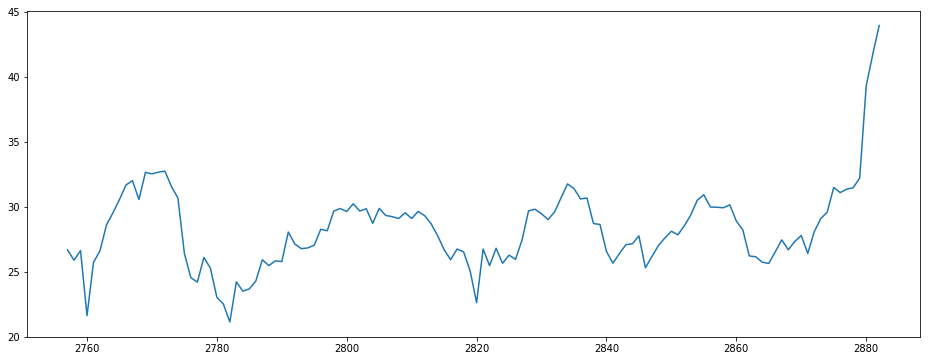

In [121]:
#2757	11/4/16 0:00	O	L	0	UP
#2883	5/9/17 0:00	C	L	15.44655386	DOWN
plt.plot(test_data.realcombo_before_std.iloc[2757:2883])

(201,)
Epoch 00055: early stopping
score on all train data is: 69.67%


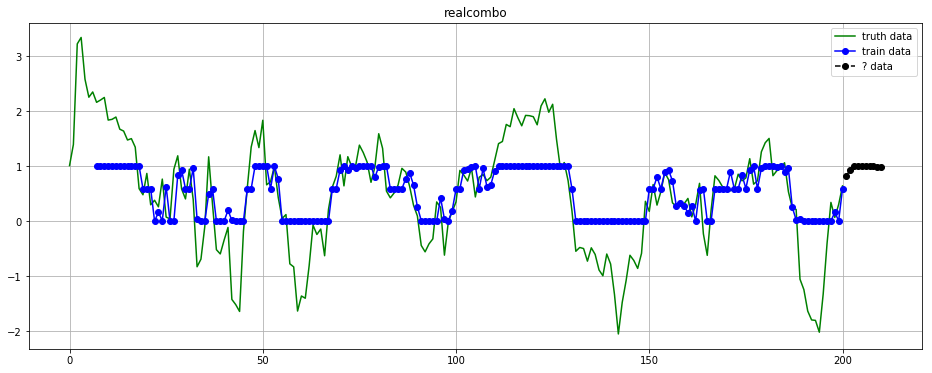

UP


In [30]:
sd=123
starting_point=3770-200
future=sl.build_model_and_predict_and_show(test_data,starting_point,starting_point+200,7)
print(sl.trendHelper(future))

Epoch 00049: early stopping
score on all train data is: 62.63%


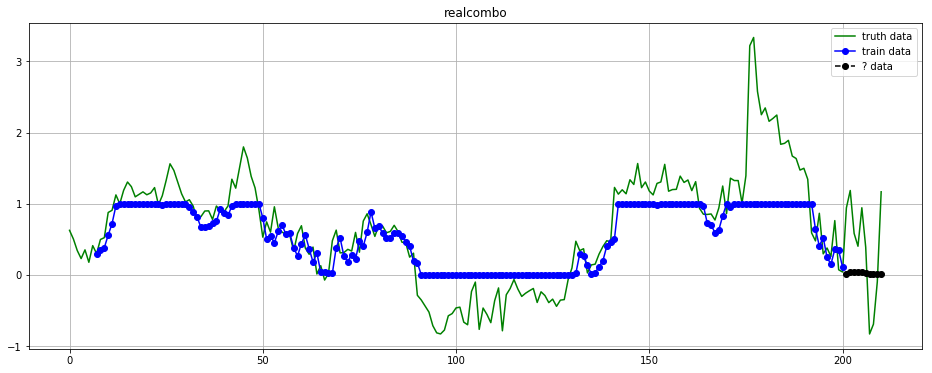

-


In [132]:
f=sl.build_model_and_predict_and_show(test_data,3396,3596,7)
print(sl.trendHelper(f))

[1.0, 0.99999976, 0.999996, 0.99994797, 0.55443513, 0.5649317, 0.34614605, 0.30958536, 0.23360142, 0.24463764]
[0, 0, 0, -1.3774043, 0, -0.6764257, 0, 0, 0]
[0, 0, -3.0088458120233574, 3.0088458120233574, -1.4776057932200277, 1.4776057932200277, 0, 0]


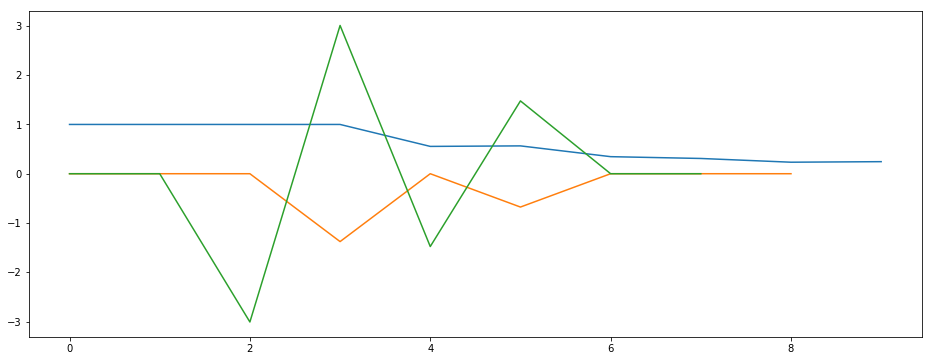

DOWN


In [11]:
future_diff1=sl.differentialHelper(future)
future_diff2=sl.differentialHelper(future_diff1)
print(future)
print(future_diff1)
print(future_diff2)
plt.plot(future)
plt.plot(future_diff1)
plt.plot(future_diff2)
plt.show()
print(sl.trendHelper(future))

In [66]:
trend_prediction=pd.read_csv('./data/lstmmodel_trend_predict_200.csv')
trend_prediction=trend_prediction.iloc[:,1:]
trend_prediction['day_index']=trend_prediction['day_index']+200

In [67]:
trend_prediction

day_index trend_predict
0         3570             -
1         3571             -
2         3572             -
3         3573             -
4         3574             -
..         ...           ...
196       3766           UP1
197       3767           UP0
198       3768           UP0
199       3769           UP0
200       3770             -

[201 rows x 2 columns]

In [66]:
trendpredict=pd.read_csv('./data/temp_data.csv',header=0)
trendpredict.head()

index trend  seed
0   2200  DOWN   123
1   2201    UP   123
2   2202  DOWN   123
3   2203  DOWN   123
4   2204  DOWN   123

In [68]:
for row in trendpredict.to_numpy():
    print(row)
    print(row[1])
    print('DOWN')
    print(type(str(row[1])))
    print(row[1]=='DOWN')
    print('DOWN'=='DOWN')
    print(type('DOWN'))
    break

[2200 'DOWN' 123]
DOWN
DOWN
<class 'str'>
True
True
<class 'str'>


In [70]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict.to_numpy(),test_data)

In [71]:
print(profit_cumulative)

120.7394072208241


In [72]:
print(transaction_list)

[[-1, '-', '-', '-', 0, '-', 0], [2200, Timestamp('2014-08-21 00:00:00'), 'O', 'S', 0, 'DOWN', 41.78538957188515], [2201, Timestamp('2014-08-22 00:00:00'), 'C', 'S', 0.6577998589526217, 'UP', 41.127589712932526], [2201, Timestamp('2014-08-22 00:00:00'), 'O', 'L', 0, 'UP', 41.127589712932526], [2202, Timestamp('2014-08-25 00:00:00'), 'C', 'L', 0.2358600692354358, 'DOWN', 41.36344978216796], [2202, Timestamp('2014-08-25 00:00:00'), 'O', 'S', 0, 'DOWN', 41.36344978216796], [2205, Timestamp('2014-08-28 00:00:00'), 'C', 'S', -0.33817850099315905, 'UP', 41.70162828316112], [2205, Timestamp('2014-08-28 00:00:00'), 'O', 'L', 0, 'UP', 41.70162828316112], [2206, Timestamp('2014-08-29 00:00:00'), 'C', 'L', 0.21343447019080486, 'DOWN', 41.915062753351926], [2206, Timestamp('2014-08-29 00:00:00'), 'O', 'S', 0, 'DOWN', 41.915062753351926], [2207, Timestamp('2014-09-02 00:00:00'), 'C', 'S', -1.1352576679706985, 'UP', 43.050320421322624], [2207, Timestamp('2014-09-02 00:00:00'), 'O', 'L', 0, 'UP', 43.

In [74]:
trend_prediction=pd.DataFrame(trendpredict, columns=('day_index', 'trend_predict','seed'))
trend_prediction.to_csv('./data/lstmmodel_trend_predict_2200_3058.csv')
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2200_3058.csv')